# import library

In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import librosa, IPython, datetime, time, os, sys, copy, dill, pickle, mir_eval, glob
import numpy as np
import pandas as pd
import IPython.display as ipd
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats import norm as stats_norm
from time import gmtime, strftime
from imageio import imread as imread
from imageio import imsave as imsave
import cv2
import librosa.display
from matplotlib import pyplot as plt
import pretty_midi
from midiutil.MidiFile import MIDIFile

import matplotlib.pyplot as plt
%matplotlib inline

print ("[info] Current Time:     " + datetime.datetime.now().strftime('%Y/%m/%d  %H:%M:%S'))
print ("[info] Python Version:   " + sys.version.split('\n')[0].split(' ')[0])
print ("[info] Working Dir:      " + os.getcwd()+'/')

[info] Current Time:     2019/10/18  20:03:17
[info] Python Version:   3.6.8
[info] Working Dir:      /host/home/python/musegan_npz/github_repository/ver2/


# Define SSM function

In [2]:
def rsssm_762(rf7_input_figure):
    save_data = rf7_input_figure;     save_file_name = './saving_tmp_file_vae1.png';
    fig = plt.figure(figsize=[8,8]);     ax = fig.add_subplot(111);
    ax.imshow(save_data,
              origin='lower', 
              cmap='hot')
    ax.axes.get_xaxis().set_visible(False);     ax.axes.get_yaxis().set_visible(False); ax.set_frame_on(False);
    plt.savefig(save_file_name,
                dpi=80,
                bbox_inches='tight',
                pad_inches=0)
    #plt.show()
    plt.close()
    #IPython.display.clear_output()
    img_readback = cv2.imread(save_file_name)
    os.remove(save_file_name)
    img_readback = np.mean(img_readback, axis=-1)
    return(-img_readback)

# Define function to read CQT data

In [3]:
read_pooled_cqt_flist = np.sort(glob.glob('./pre_processed_data/cqt_pooled_data/*.pkl', recursive=True)).tolist()

print ('Total files: {}'.format(len(read_pooled_cqt_flist)))
for x in read_pooled_cqt_flist[:3]: print (x)

def read_pooled_cqt(file_idx,
                    read_pooled_cqt_flist=read_pooled_cqt_flist):
    
    file_name = read_pooled_cqt_flist[file_idx]
    with open(file_name, 'rb') as pkl_file:
        pooled_cqt_data = pickle.load(pkl_file)
        
    return (pooled_cqt_data)

#print(len(read_pooled_cqt(0)))
#print(read_pooled_cqt(0)[0].shape)

Total files: 24
./pre_processed_data/cqt_pooled_data/01_A_Hard_Days_Night_no_drum.pkl
./pre_processed_data/cqt_pooled_data/02_Anna_no_drum.pkl
./pre_processed_data/cqt_pooled_data/03_Back_In_The_USSR_no_drum.pkl


# Reload 46-inst drum MIDI data

In [4]:
file_name = 'song_drum_bar_list_46.pkl'
folder_name = './pre_processed_data/cdsed_drum_bar_list_28_46/'
full_file_name = folder_name + file_name
    
with open(full_file_name, 'rb') as pkl_file:
    song_drum_bar_list_46 = pickle.load(pkl_file)

song_idx = 0; bar_idx = 0;
total_songs = len(song_drum_bar_list_46)

print('[info] Songs reloaded: {}'.format(total_songs))
#print(song_drum_bar_list_46[song_idx][bar_idx].shape)

[info] Songs reloaded: 24


# Get bar index

In [5]:
# Get bar num list
bar_num_list1 = []; bar_num_list2 = [];

for song_idx in range(0, total_songs):
    
    bar_num_list1.append(len(song_drum_bar_list_46[song_idx]))
    bar_num_list2.append(len(read_pooled_cqt(song_idx)))
    

# Get absolute bar index
abs_bar_idx_str_list = []

for song_idx in range(0, total_songs):
    
    song_idx_str = "{:0>5}".format(song_idx)
    
    total_bars = len(song_drum_bar_list_46[song_idx])
    
    for bar_idx in range(0, total_bars):
        
        bar_idx_str = "{:0>3}".format(bar_idx)
        
        abs_bar_idx_str = song_idx_str + "_" + bar_idx_str
        
        abs_bar_idx_str_list.append(abs_bar_idx_str)


# save abs_bar_idx_list
with open('./pre_processed_data/abs_bar_idx_str_list.pkl', 'wb') as pkl_file:
    pickle.dump(abs_bar_idx_str_list, pkl_file)
    
print('[info] bar index info reloaded.')

[info] bar index info reloaded.


# Get spectrogram by index

In [6]:
def get_cqt_by_abs_bar_idx(abs_bar_idx):
    
    song_idx_int = int(abs_bar_idx.split("_")[0])
    bar_idx_int = int(abs_bar_idx.split("_")[1])
    
    reload_cqt_data = read_pooled_cqt(song_idx_int)[bar_idx_int]
    reload_drum_data = song_drum_bar_list_46[song_idx][bar_idx]
    
    return (reload_cqt_data, reload_drum_data)

cqt_data, drum_data = get_cqt_by_abs_bar_idx(abs_bar_idx_str_list[0])
print(cqt_data.shape)
print(drum_data.shape)

(84, 96)
(46, 16)


# Reload SSM data

[info] Song index: 1
[info] SSM shape: (81, 81)


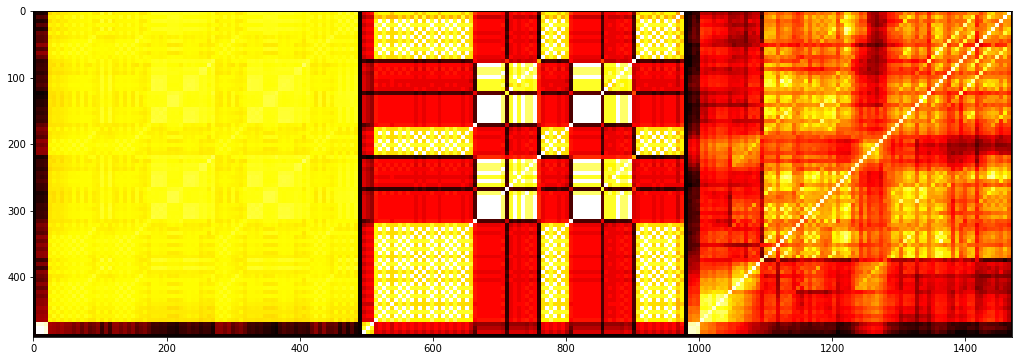

In [7]:
# load 24 test files SSM
with open('./pre_processed_data/model_out_drum_ssm_pkg.pkl', 'rb') as pkl_file:
    ssm_data_pkg_list = pickle.load(pkl_file)
    
song_idx = 1

song_bars_num =  ssm_data_pkg_list[0][song_idx]
cqt_ssm =        ssm_data_pkg_list[1][song_idx]
drum_ssm =       ssm_data_pkg_list[2][song_idx]
drum_model_ssm = ssm_data_pkg_list[3][song_idx]

print ('[info] Song index: {}'.format(song_idx))
print ('[info] SSM shape: {}'.format(drum_model_ssm.shape))

merged_plot_data = np.hstack([rsssm_762(cqt_ssm), 
                              rsssm_762(drum_ssm), 
                              rsssm_762(drum_model_ssm)])
plt.figure(figsize=(6*3, 6)); plt.imshow(merged_plot_data, cmap='hot'); plt.show();

# Check original drum SSM value range

In [8]:
data_avg_v_list = []; data_std_v_list = []; data_max_v_list = []; data_min_v_list = [];

tota_files = len(ssm_data_pkg_list[0])

for song_idx in range(0, tota_files):

    drum_ssm_data = ssm_data_pkg_list[2][song_idx]
    
    #print (drum_ssm_data.shape)
    
    data_avg_v_list.append(np.mean(drum_ssm_data))
    data_std_v_list.append(np.std(drum_ssm_data))
    data_max_v_list.append(np.max(drum_ssm_data))
    data_min_v_list.append(np.min(drum_ssm_data))
    
print ('[info] All {} files processed.'.format(tota_files))
print("[info] pix value avg: {:.5f}".format(np.mean(data_avg_v_list)))
print("[info] pix value std: {:.5f}".format(np.mean(data_std_v_list)))
print("[info] pix value max: {:.5f}".format(np.max(data_max_v_list)))
print("[info] pix value min: {:.5f}".format(np.min(data_min_v_list)))

[info] All 24 files processed.
[info] pix value avg: 0.15299
[info] pix value std: 0.10520
[info] pix value max: 0.44721
[info] pix value min: 0.00000


# Check VAE-GAN generated drum SSM value range

In [9]:
data_avg_v_list = []; data_std_v_list = []; data_max_v_list = []; data_min_v_list = [];

tota_files = len(ssm_data_pkg_list[0])

for song_idx in range(0, tota_files):

    drum_ssm_data = ssm_data_pkg_list[3][song_idx]
    
    data_avg_v_list.append(np.mean(drum_ssm_data))
    data_std_v_list.append(np.std(drum_ssm_data))
    data_max_v_list.append(np.max(drum_ssm_data))
    data_min_v_list.append(np.min(drum_ssm_data))
    
print ('[info] All {} files processed.'.format(tota_files))
print("[info] pix value avg: {:.5f}".format(np.mean(data_avg_v_list)))
print("[info] pix value std: {:.5f}".format(np.mean(data_std_v_list)))
print("[info] pix value max: {:.5f}".format(np.max(data_max_v_list)))
print("[info] pix value min: {:.5f}".format(np.min(data_min_v_list)))

[info] All 24 files processed.
[info] pix value avg: 0.16442
[info] pix value std: 0.07791
[info] pix value max: 0.43875
[info] pix value min: -0.04643


# define function get_bar_dist

In [10]:
def get_bar_dist(gbd_total_bars, gbd_self_bar_idx, dist_base_v):
    
    data_dist_list = []
    
    for bar_idx in range(0, gbd_total_bars):
        get_distance = np.abs(bar_idx - gbd_self_bar_idx) * dist_base_v
        data_dist_list.append(get_distance)
        
    data_dist_ary = np.array(data_dist_list)
    
    return (data_dist_ary)


def get_cqt_ratio_by_distance(gcr_in):
    
    drum_ssm_max_distance = 1.0
    
    # normalize value into [0.0 ~ 1.0]
    gcr_out = gcr_in / drum_ssm_max_distance
    
    # inverse ratio
    gcr_out = 1.0 - gcr_out
    
    # make sure all value in value range
    gcr_out[gcr_out>=1.0] = 1.0;     gcr_out[gcr_out<=0.0] = 0.0;
    
    return gcr_out

print ("[info] Function defined.")

[info] Function defined.


# Get bars correlation value & index (from VAE-GAM generated SSM)

In [11]:
songs_high_correlation_bars_list = []

total_files = len(ssm_data_pkg_list[2])

# loop over all files
for song_idx in range(0, total_files):
        
    ssm_data_reload = ssm_data_pkg_list[2][song_idx]

    high_correlation_bars_list = []

    song_len = ssm_data_reload.shape[0]
    
    # get how many similar bars data
    k_nearest = 16

    #k_nearest = min(k_nearest, song_len)
    k_nearest = song_len

    ssm_max_v = np.max(ssm_data_reload)

    for bar_idx in range(0, song_len):
        
        bar_correlation_data_raw = ssm_data_reload[:, bar_idx].copy()
        
        bar_correlation_data = bar_correlation_data_raw.copy()
        
        # make self distance max value
        bar_correlation_data[bar_idx] = ssm_max_v        
        
        # add small value to make sure near bars are closer in ranking
        dist_base_v = 1e-3
        
        bar_correlation_data += get_bar_dist(song_len, bar_idx, dist_base_v)
        
        ssm_bar_dist_original = bar_correlation_data_raw
        nearest_bar_k_index = np.argsort(bar_correlation_data)[:k_nearest]
        nearest_bar_k_value = np.sort(bar_correlation_data)[:k_nearest]       
        nearest_bar_k_ratio = get_cqt_ratio_by_distance(nearest_bar_k_value)
        
        high_correlation_bars_list.append(np.vstack([ssm_bar_dist_original, 
                                                     nearest_bar_k_index, 
                                                     nearest_bar_k_value,
                                                     nearest_bar_k_ratio]))
        
    high_correlation_bars_ary = np.array(high_correlation_bars_list)
    
    songs_high_correlation_bars_list.append(high_correlation_bars_ary)
    
    print ('song idx: {:3d}, result format: {}'.format(song_idx, high_correlation_bars_ary.shape))
    
print ('\n[info] All {} songs process done.'.format(total_files))

song idx:   0, result format: (101, 4, 101)
song idx:   1, result format: (81, 4, 81)
song idx:   2, result format: (91, 4, 91)
song idx:   3, result format: (94, 4, 94)
song idx:   4, result format: (86, 4, 86)
song idx:   5, result format: (84, 4, 84)
song idx:   6, result format: (101, 4, 101)
song idx:   7, result format: (91, 4, 91)
song idx:   8, result format: (88, 4, 88)
song idx:   9, result format: (79, 4, 79)
song idx:  10, result format: (140, 4, 140)
song idx:  11, result format: (68, 4, 68)
song idx:  12, result format: (74, 4, 74)
song idx:  13, result format: (62, 4, 62)
song idx:  14, result format: (109, 4, 109)
song idx:  15, result format: (67, 4, 67)
song idx:  16, result format: (111, 4, 111)
song idx:  17, result format: (95, 4, 95)
song idx:  18, result format: (52, 4, 52)
song idx:  19, result format: (118, 4, 118)
song idx:  20, result format: (140, 4, 140)
song idx:  21, result format: (133, 4, 133)
song idx:  22, result format: (100, 4, 100)
song idx:  23, r

# Keep useful data

In [12]:
vaegan_bar_selection_index_list = []

for song_idx in range(0, total_files):
    
    vaegan_bar_selection_index_list.append(songs_high_correlation_bars_list[song_idx][:,[1,3],0:8])
    
print ('file is prossed.')

print(vaegan_bar_selection_index_list[0].shape)
print(vaegan_bar_selection_index_list[1].shape)
print(vaegan_bar_selection_index_list[2].shape)

# show data format
vaegan_bar_selection_index_list[0][0,:,:5]

file is prossed.
(101, 2, 8)
(81, 2, 8)
(91, 2, 8)


array([[ 3.        ,  4.        , 85.        , 86.        , 87.        ],
       [ 0.99699998,  0.99599999,  0.91500002,  0.91399997,  0.91299999]])

# Save index list

In [13]:
file_name = './pre_processed_data/vaegan_bar_selection_index_list.pkl'
with open(file_name, 'wb') as pkl_file:
    pickle.dump(vaegan_bar_selection_index_list, pkl_file)
print ('[info] File saved.')

[info] File saved.


# Reload Song attribute data

In [14]:
file_name = './pre_processed_data/cdsed_drum_bar_list_28_46/song_drum_bar_list_46.pkl'   
with open(file_name, 'rb') as pkl_file:
    song_drum_bar_list_46 = pickle.load(pkl_file)

song_bar_note_num_list = []

for song_idx in range(0, total_songs):
    bar_num_in_song = len(song_drum_bar_list_46[song_idx])
    bar_note_num_list = [np.round(np.sum(song_drum_bar_list_46[song_idx][bar_idx])).astype(np.float32) for bar_idx in range(bar_num_in_song)]    
    song_bar_note_num_list.append(bar_note_num_list)

# define soft one hot function

In [15]:
# x input range = (0.0 , 1.0)
def get_soft_one_hot(gsoh_x, gsoh_bit_width=10):
    
    gsoh_x = min(gsoh_x, 1.0)
    gsoh_x = max(gsoh_x, 0.0)

    gsoh_x_scaled = gsoh_x * (gsoh_bit_width-1.0)
    
    gsoh_norm_ratio = 1.0 / stats_norm.pdf(0)    
    dist_fat_index = 1
    gsoh_out_list = [gsoh_norm_ratio * stats_norm.pdf((gsoh_x_scaled-offset)*(1./dist_fat_index)) for offset in range(gsoh_bit_width)]    
    gsoh_out_list = [x*100.0 for x in gsoh_out_list]
    
    return(gsoh_out_list)

print ('[info] One Hot function defined.')

[info] One Hot function defined.


# Generate attribute list

In [16]:
print ('[info] Start converstion...')
print ('[info] ' + datetime.datetime.now().strftime('%Y/%m/%d  %H:%M:%S') + '\n')

all_merged_attribute_list = []

loop_n_files = len(song_bar_note_num_list)

for song_idx in range(0, loop_n_files):
    
    # get soft one hot tempo
    tempo_value = 120
    tempo_norm_v = (tempo_value - 60.0)*(1.0/90.0)
    tempo_norm_v_oh = np.array(get_soft_one_hot(tempo_norm_v))
    
    # get soft one hot style
    style_value = 15
    style_tag_array_oh = np.zeros([16])
    style_tag_array_oh[style_value] = 100.0
    
    n_note_in_bars_ary = np.array(song_bar_note_num_list[song_idx])
    n_bars_in_song = len(song_drum_bar_list_46[song_idx])
    
    # get soft one hot progress value
    progress_ratio_list = [(x+1)/n_bars_in_song for x in range(n_bars_in_song)]
    song_progress_oh = np.array([np.array(get_soft_one_hot(x)) for x in progress_ratio_list])
    
    all_merged_drum_data = [n_bars_in_song,
                            tempo_norm_v_oh,
                            style_tag_array_oh,
                            song_progress_oh,
                            n_note_in_bars_ary]
    
    
    all_merged_attribute_list.append(all_merged_drum_data)
    

    if (song_idx+1)%1==0:
        
        print ('[info] Song processed: {}, bars: {}, T: {}, S: {}, P: {}, N: {}'.format(song_idx+1, 
                                                                                        n_bars_in_song, 
                                                                                        tempo_norm_v_oh.shape,
                                                                                        style_tag_array_oh.shape,
                                                                                        song_progress_oh.shape,
                                                                                        n_note_in_bars_ary.shape))

print ('\n[info] All files are processed.')
print (datetime.datetime.now().strftime('%Y/%m/%d  %H:%M:%S'))

# save all attribute
file_name = './pre_processed_data/all_song_attribute.pkl'
with open(file_name, 'wb') as pkl_file:
    pickle.dump(all_merged_attribute_list, pkl_file)
    
print ('\n[info] file is saved.')

[info] Start converstion...
[info] 2019/10/18  20:03:21

[info] Song processed: 1, bars: 101, T: (10,), S: (16,), P: (101, 10), N: (101,)
[info] Song processed: 2, bars: 81, T: (10,), S: (16,), P: (81, 10), N: (81,)
[info] Song processed: 3, bars: 91, T: (10,), S: (16,), P: (91, 10), N: (91,)
[info] Song processed: 4, bars: 94, T: (10,), S: (16,), P: (94, 10), N: (94,)
[info] Song processed: 5, bars: 86, T: (10,), S: (16,), P: (86, 10), N: (86,)
[info] Song processed: 6, bars: 84, T: (10,), S: (16,), P: (84, 10), N: (84,)
[info] Song processed: 7, bars: 101, T: (10,), S: (16,), P: (101, 10), N: (101,)
[info] Song processed: 8, bars: 91, T: (10,), S: (16,), P: (91, 10), N: (91,)
[info] Song processed: 9, bars: 88, T: (10,), S: (16,), P: (88, 10), N: (88,)
[info] Song processed: 10, bars: 79, T: (10,), S: (16,), P: (79, 10), N: (79,)
[info] Song processed: 11, bars: 140, T: (10,), S: (16,), P: (140, 10), N: (140,)
[info] Song processed: 12, bars: 68, T: (10,), S: (16,), P: (68, 10), N: (